In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.statespace import sarimax

import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv('data_train.csv', index_col=['timestamp'], parse_dates=['timestamp'])
train_data = train_data.asfreq('h') #  чтобы не появлялось исключение при обучении модели
train_data.head()

,fact
timestamp,
2019-01-01 00:00:00,294.0
2019-01-01 01:00:00,292.0
2019-01-01 02:00:00,290.0
2019-01-01 03:00:00,293.0
2019-01-01 04:00:00,294.0


Критерий Дики-Фуллера: p=0.000000


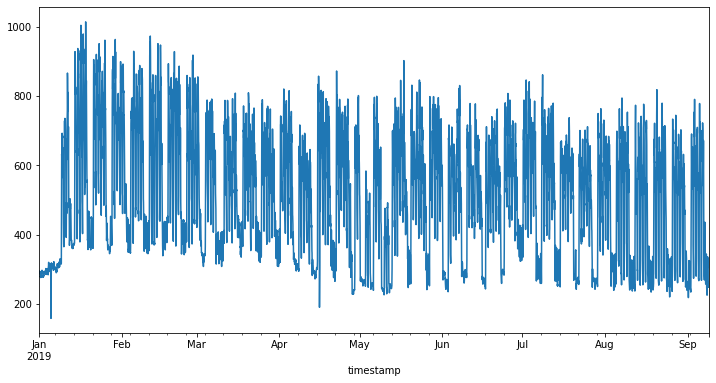

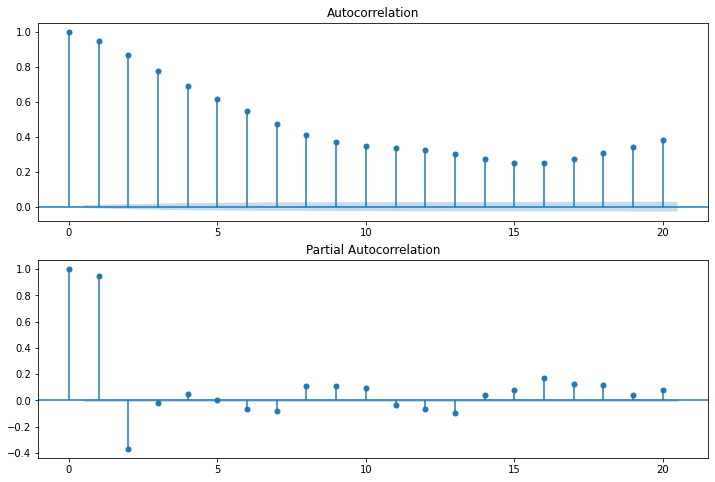

In [3]:
def tsplot(data, lags=None):
    
    data.plot(figsize=(12,6))    
    fig = plt.figure(figsize=(12,8))
    
    ax1 = fig.add_subplot(211)
    fig = smt.graphics.plot_acf(data, lags=lags, ax = ax1, alpha=0.5)
    
    ax2 = fig.add_subplot(212)
    fig2 = smt.graphics.plot_pacf(data, lags=lags, ax = ax2, alpha=0.5)
    
    print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data)[1])


tsplot(train_data.fact, lags=20)

In [4]:
train_data = train_data.loc['2019-8-5':] #  для обучения будет использоваться часть датасета (начиная с первого понедельника августа)
train_data.head()

,fact
timestamp,
2019-08-05 00:00:00,262.0
2019-08-05 01:00:00,264.0
2019-08-05 02:00:00,257.0
2019-08-05 03:00:00,273.0
2019-08-05 04:00:00,280.0


Критерий Дики-Фуллера: p=0.385059


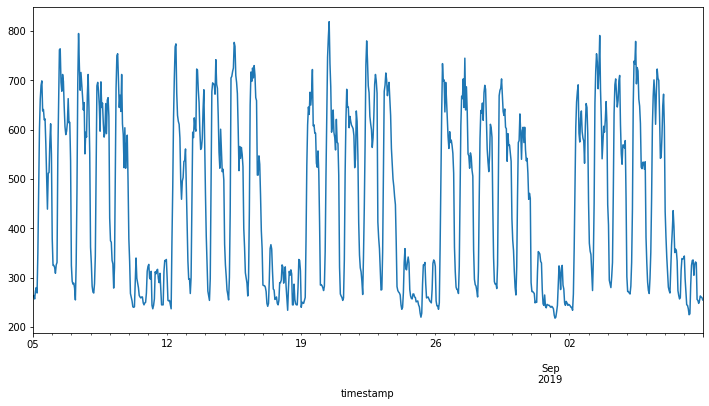

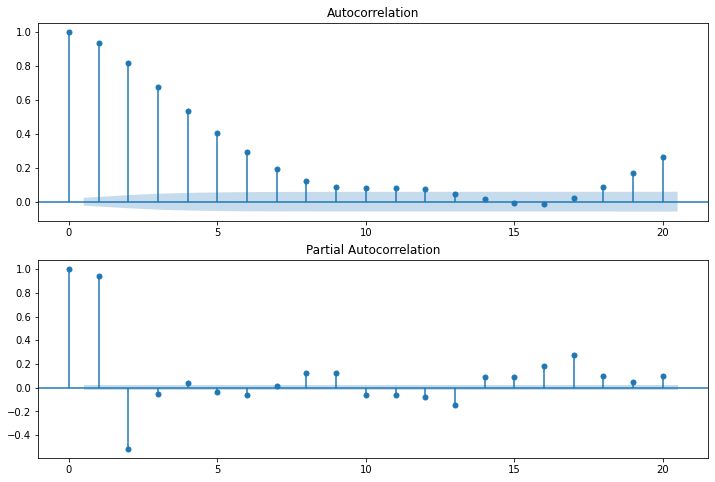

In [5]:
tsplot(train_data.fact, lags=20)

Критерий Дики-Фуллера: p=0.000000


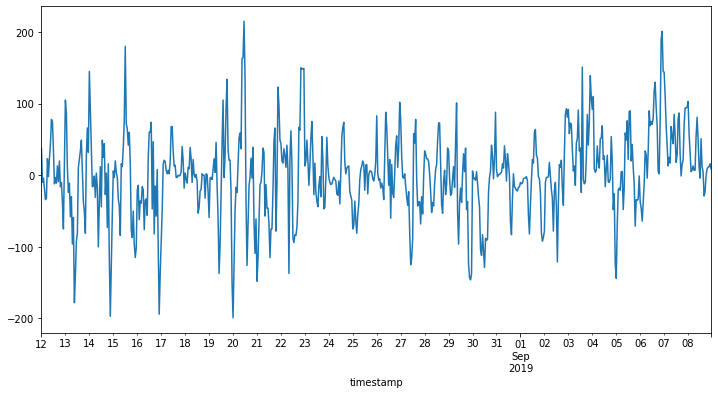

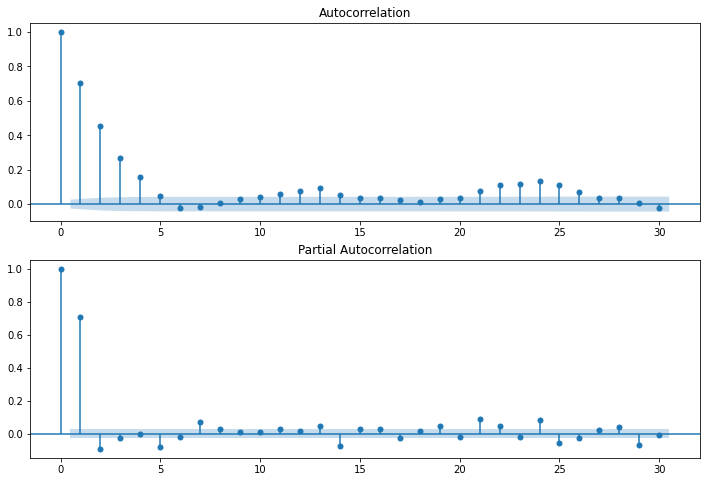

In [6]:
train_data['fact_season'] = train_data.fact - train_data.fact.shift(24*7)
tsplot(train_data.fact_season[24*7:], lags=30)

Критерий Дики-Фуллера: p=0.000000


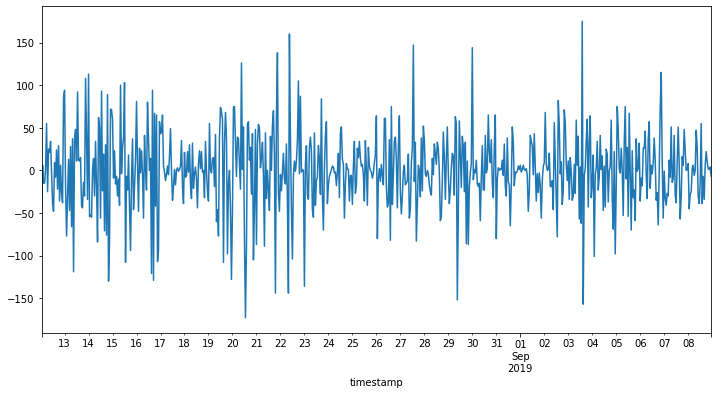

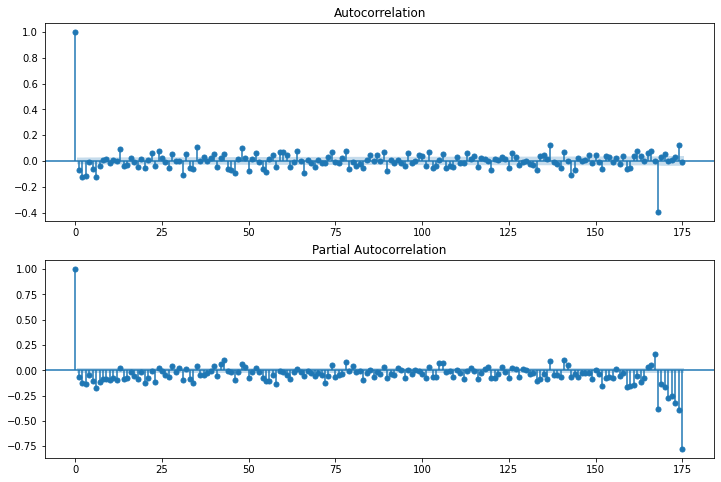

In [7]:
train_data['fact_season_diff'] = train_data.fact_season - train_data.fact_season.shift(1)
tsplot(train_data.fact_season_diff[24*7+1:], lags=np.arange(0, 176))

Ради экономии времени обучение модели не производится, для прогнозирования загружается предварительно обученная модель

In [8]:
# model = sm.tsa.statespace.SARIMAX(train_data.fact, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24*7))
# model_fit = model.fit(low_memory=True, disp=-1)
# print(model_fit.summary())  

In [9]:
#model_fit.save("model_temp.txt")

In [10]:
model_fit = sarimax.SARIMAXResults.load("model.txt")

In [11]:
fact = train_data["fact"]
predictions = model_fit.predict()
forecast = model_fit.predict(start = train_data.shape[0], end = train_data.shape[0]+24*14)

RMSE c 05.08 по 08.09: 45.1661662641494


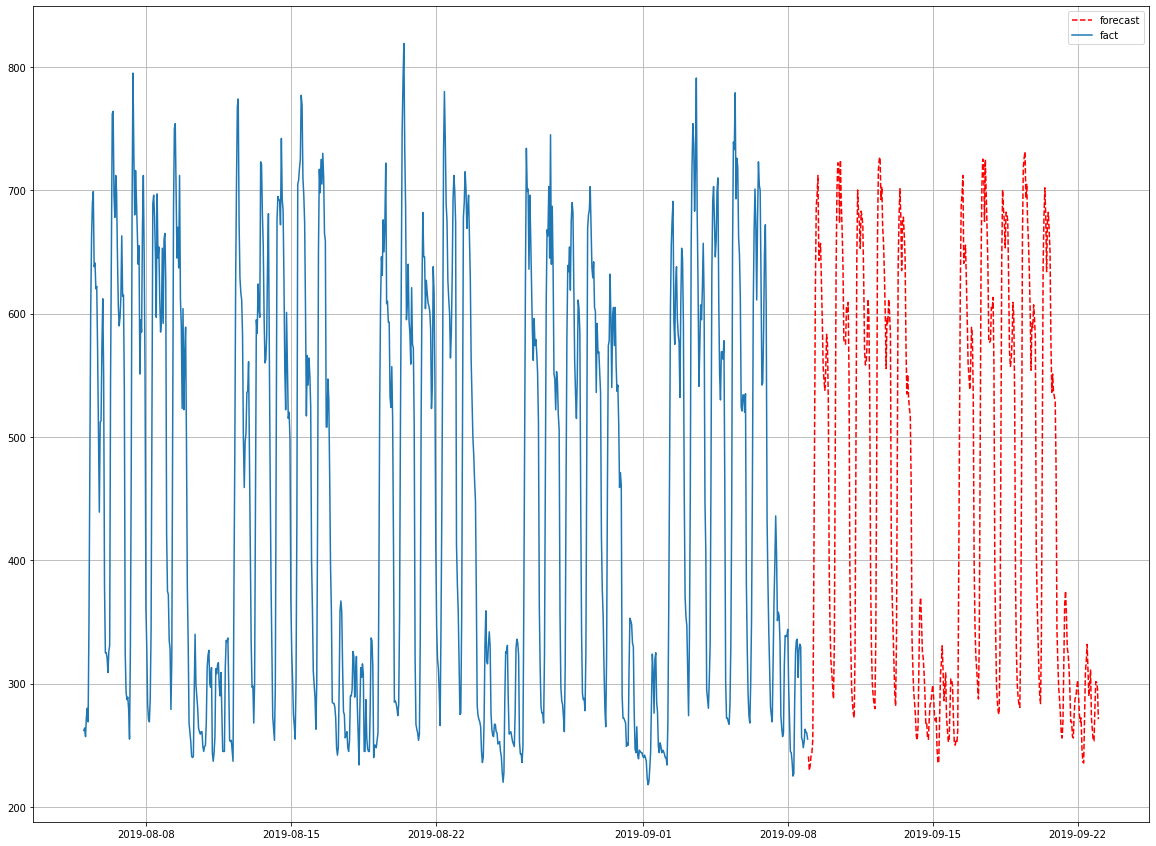

In [12]:
print('RMSE c 05.08 по 08.09:', mean_squared_error(fact, predictions, squared = False))

plt.figure(figsize=(20, 15))
plt.plot(forecast, color='r', linestyle = '--', label="forecast")
#plt.plot(predictions, color='r', label="model") # закомментировано для улучшения читаемости графиков
plt.plot(fact, label="fact")
plt.legend()
plt.grid(True)

In [13]:
train_data.tail()

,fact,fact_season,fact_season_diff
timestamp,,,
2019-09-08 19:00:00,253.0,9.0,10.0
2019-09-08 20:00:00,263.0,11.0,2.0
2019-09-08 21:00:00,261.0,12.0,1.0
2019-09-08 22:00:00,260.0,16.0,4.0
2019-09-08 23:00:00,255.0,9.0,-7.0


In [14]:
forecast = pd.DataFrame(forecast)
forecast.reset_index(inplace = True)
forecast.columns = ['timestamp', 'predicted']
forecast.head()

,timestamp,predicted
0,2019-09-09 00:00:00,241.036493
1,2019-09-09 01:00:00,229.532679
2,2019-09-09 02:00:00,233.537007
3,2019-09-09 03:00:00,241.872479
4,2019-09-09 04:00:00,244.096632


In [15]:
forecast.to_csv("forecast.csv", encoding='utf-8', index=False)